In [40]:
#Basic Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [1]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

# Introduction

<em>A logistics and delivery startup wants to evaluate their customers satisfaction after facing multiple challenges in on-demand delivery during the pandemic. 
    
A sample of surveys* are given by the customer with the following details:
    
- Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers
- X1 = my order was delivered on time
- X2 = contents of my order was as I expected
- X3 = I ordered everything I wanted to order
- X4 = I paid a good price for my order
- X5 = I am satisfied with my courier
- X6 = the app makes ordering easy for me

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.

The goal is to predict if a customer is happy or not based on the answers they give to questions asked. Two success metrics are given:
    
 - Reach 73% accuracy score or above, or convince us why your solution is superior. We are definitely interested in every solution and insight you can provide us.
 - We are very interested in finding which questions/features are more important when predicting a customer’s happiness. Using a feature selection approach show us understand what is the minimal set of attributes/features that would preserve the most information about the problem while increasing predictability of the data we have. Is there any question that we can remove in our next survey?
    

* Data is deleted in the repository since it's of private nature. Notebook is displayed with the analysis


## Import the data and Exploration

In [42]:
#Import the csv file
customer_data=pd.read_csv('ACME-HappinessSurvey2020.csv')
customer_data.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [4]:
customer_data.shape

(126, 7)

In [43]:
#General view of the data
customer_data.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [44]:
#Looking for null values
customer_data.isnull().sum()

Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
dtype: int64

In [45]:
customer_data.duplicated().any()

True

In [46]:
customer_data[customer_data.duplicated()]

,Y,X1,X2,X3,X4,X5,X6
4,0,5,4,3,3,3,5
22,0,4,3,5,5,5,4
28,1,3,3,1,3,3,4
33,1,3,2,4,4,4,5
37,1,5,3,4,3,4,5
50,1,5,1,3,3,4,4
51,1,5,1,3,3,4,4
53,1,5,2,4,3,4,5
55,1,4,3,2,4,3,4
62,1,5,2,4,4,5,5


In [8]:
(customer_data['Y']==0) & (customer_data['X1']==5) & (customer_data['X2']==4) & (customer_data['X3']==3) & (customer_data['X4']==3) & (customer_data['X5']==3) & (customer_data['X6']==5)

0      False
1      False
2      False
3       True
4       True
       ...  
121    False
122    False
123    False
124    False
125    False
Length: 126, dtype: bool

In [9]:
customer_data[(customer_data['Y']==0) & (customer_data['X1']==5) & (customer_data['X2']==4) & (customer_data['X3']==3) & (customer_data['X4']==3) & (customer_data['X5']==3) & (customer_data['X6']==5)]

,Y,X1,X2,X3,X4,X5,X6
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [49]:
new_customer_data=customer_data.drop_duplicates()
new_customer_data.shape

(110, 7)

In [47]:
#Exploring correlations
customer_data.corr()

,Y,X1,X2,X3,X4,X5,X6
Y,1.000000,0.280160,-0.024274,0.150838,0.064415,0.224522,0.167669
X1,0.280160,1.000000,0.059797,0.283358,0.087541,0.432772,0.411873
X2,-0.024274,0.059797,1.000000,0.184129,0.114838,0.039996,-0.062205
X3,0.150838,0.283358,0.184129,1.000000,0.302618,0.358397,0.203750
X4,0.064415,0.087541,0.114838,0.302618,1.000000,0.293115,0.215888
X5,0.224522,0.432772,0.039996,0.358397,0.293115,1.000000,0.320195
X6,0.167669,0.411873,-0.062205,0.203750,0.215888,0.320195,1.000000


In [50]:
new_customer_data.Y.value_counts()

1    56
0    54
Name: Y, dtype: int64

<b> There are some outliers, but that is to be expected in questionnaires with a limited range of values <b> 

## Using PyCaret: inspecting models

In [53]:
#Import classification modules
from pycaret.classification import *


In [54]:
#Setup a classification model
class_model = setup(customer_data, 
                       target = 'Y', 
                       session_id=123, 
                       log_experiment=True, 
                       experiment_name='customer_survey')

,Description,Value
0,session_id,123
1,Target,Y
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(126, 7)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,6
8,Ordinal Features,False
9,High Cardinality Features,False


In [55]:
#Retrieve best models
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6736,0.6869,0.8400,0.6838,0.7467,0.3005,0.3215,0.0160
xgboost,Extreme Gradient Boosting,0.6500,0.6792,0.6833,0.6988,0.6838,0.2830,0.2867,0.1400
rf,Random Forest Classifier,0.6056,0.6719,0.7433,0.6315,0.6771,0.1600,0.1793,0.1570
dt,Decision Tree Classifier,0.6014,0.5858,0.6833,0.6540,0.6590,0.1746,0.1851,0.0120
ridge,Ridge Classifier,0.5931,0.0000,0.7400,0.6000,0.6584,0.1334,0.1619,0.0110
lr,Logistic Regression,0.5819,0.6053,0.7200,0.5952,0.6478,0.1115,0.1337,0.0170
lda,Linear Discriminant Analysis,0.5819,0.5642,0.7033,0.6152,0.6533,0.1242,0.1331,0.0130
svm,SVM - Linear Kernel,0.5806,0.0000,0.6833,0.6328,0.6342,0.0986,0.1060,0.0110
dummy,Dummy Classifier,0.5806,0.5000,1.0000,0.5806,0.7338,0.0000,0.0000,0.0080
gbc,Gradient Boosting Classifier,0.5708,0.6058,0.7000,0.5969,0.6391,0.0885,0.1097,0.0490


In [57]:
#Looking at the best model
print(best_model)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')


In [58]:
#Create a knn model
knn = create_model('knn')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8889,0.9444,1.0000,0.8571,0.9231,0.7273,0.7559
1,0.5556,0.4500,0.6000,0.6000,0.6000,0.1000,0.1000
2,0.5556,0.6000,0.8000,0.5714,0.6667,0.0526,0.0598
3,0.4444,0.5750,0.6000,0.5000,0.5455,-0.1538,-0.1581
4,0.7778,0.8000,1.0000,0.7143,0.8333,0.5263,0.5976
5,0.6667,0.7500,0.8000,0.6667,0.7273,0.3077,0.3162
6,0.4444,0.2500,0.8000,0.5000,0.6154,-0.2162,-0.3162
7,0.7778,1.0000,1.0000,0.7143,0.8333,0.5263,0.5976
8,0.7500,0.6667,1.0000,0.7143,0.8333,0.3846,0.4880


In [60]:
#Instance of second best model
xgboost= create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7778,0.8333,0.8333,0.8333,0.8333,0.5000,0.5000
1,0.4444,0.4500,0.4000,0.5000,0.4444,-0.0976,-0.1000
2,0.6667,0.6000,0.8000,0.6667,0.7273,0.3077,0.3162
3,0.6667,0.7000,0.6000,0.7500,0.6667,0.3415,0.3500
4,0.7778,0.9500,0.8000,0.8000,0.8000,0.5500,0.5500
5,0.5556,0.7000,0.4000,0.6667,0.5000,0.1429,0.1581
6,0.5556,0.3750,0.6000,0.6000,0.6000,0.1000,0.1000
7,0.5556,0.6500,0.8000,0.5714,0.6667,0.0526,0.0598
8,0.7500,0.6667,0.8000,0.8000,0.8000,0.4667,0.4667


In [127]:
#Instance of 3 best model
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6667,0.7778,0.8333,0.7143,0.7692,0.1818,0.1890
1,0.4444,0.4000,0.6000,0.5000,0.5455,-0.1538,-0.1581
2,0.5556,0.6000,0.6000,0.6000,0.6000,0.1000,0.1000
3,0.5556,0.7000,0.6000,0.6000,0.6000,0.1000,0.1000
4,0.8889,0.9500,1.0000,0.8333,0.9091,0.7692,0.7906
5,0.4444,0.6000,0.4000,0.5000,0.4444,-0.0976,-0.1000
6,0.3333,0.4250,0.6000,0.4286,0.5000,-0.4211,-0.4781
7,0.6667,0.8000,1.0000,0.6250,0.7692,0.2703,0.3953
8,0.7500,0.7333,1.0000,0.7143,0.8333,0.3846,0.4880


In [108]:
#Tuning the best 3 models
tune_knn=tune_model(knn)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7778,0.8611,0.8333,0.8333,0.8333,0.5000,0.5000
1,0.4444,0.4000,0.4000,0.5000,0.4444,-0.0976,-0.1000
2,0.7778,0.6250,1.0000,0.7143,0.8333,0.5263,0.5976
3,0.5556,0.7000,0.6000,0.6000,0.6000,0.1000,0.1000
4,0.7778,0.9500,1.0000,0.7143,0.8333,0.5263,0.5976
5,0.7778,0.7000,1.0000,0.7143,0.8333,0.5263,0.5976
6,0.3333,0.3500,0.6000,0.4286,0.5000,-0.4211,-0.4781
7,0.6667,1.0000,1.0000,0.6250,0.7692,0.2703,0.3953
8,0.7500,0.6000,1.0000,0.7143,0.8333,0.3846,0.4880


In [109]:
tune_xgb=tune_model(xgboost)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6667,0.7778,1.0000,0.6667,0.8000,0.0000,0.0000
1,0.5556,0.4000,1.0000,0.5556,0.7143,0.0000,0.0000
2,0.6667,0.9000,1.0000,0.6250,0.7692,0.2703,0.3953
3,0.5556,0.5500,1.0000,0.5556,0.7143,0.0000,0.0000
4,0.6667,0.8000,1.0000,0.6250,0.7692,0.2703,0.3953
5,0.6667,0.7000,1.0000,0.6250,0.7692,0.2703,0.3953
6,0.5556,0.1750,1.0000,0.5556,0.7143,0.0000,0.0000
7,0.6667,0.8000,1.0000,0.6250,0.7692,0.2703,0.3953
8,0.7500,0.4667,1.0000,0.7143,0.8333,0.3846,0.4880


In [110]:
tune_rf=tune_model(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7778,0.8889,0.8333,0.8333,0.8333,0.5000,0.5000
1,0.2222,0.2500,0.2000,0.2500,0.2222,-0.5366,-0.5500
2,0.6667,0.8000,0.8000,0.6667,0.7273,0.3077,0.3162
3,0.4444,0.5500,0.4000,0.5000,0.4444,-0.0976,-0.1000
4,0.7778,0.8500,0.6000,1.0000,0.7500,0.5714,0.6325
5,0.6667,0.8000,0.6000,0.7500,0.6667,0.3415,0.3500
6,0.4444,0.2750,0.2000,0.5000,0.2857,-0.0465,-0.0598
7,0.5556,0.8000,0.8000,0.5714,0.6667,0.0526,0.0598
8,0.8750,0.7333,1.0000,0.8333,0.9091,0.7143,0.7454


## Feature Importance

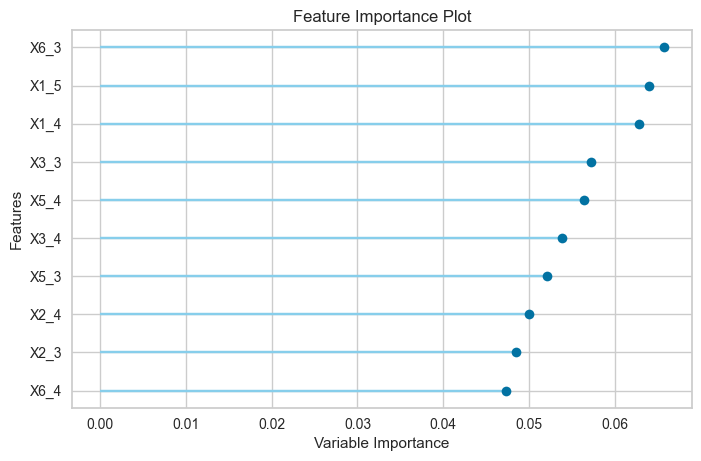

In [73]:
plot_model(rf,plot='feature')

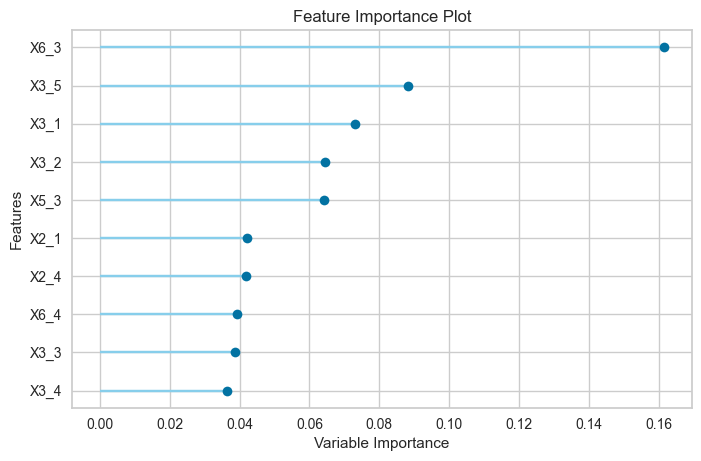

In [86]:
plot_model(xgboost,plot='feature')

In [90]:
#Using SHAP
import shap

In [122]:
# Split data
from sklearn.model_selection import train_test_split
X = customer_data.drop('Y',axis=1)
X=pd.get_dummies(data=X, columns=['X1','X2','X3','X4','X5','X6'])
y = customer_data['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Copy random forest from pycaret
random_forest=rf
# Fits the model on the data
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

In [123]:
# Fits the explainer
explainer = shap.Explainer(random_forest.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

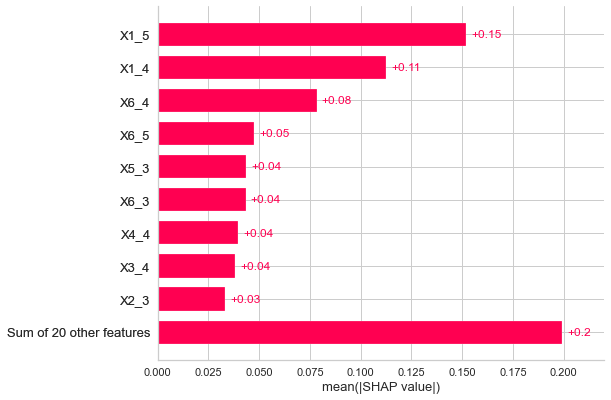

In [124]:
# Plotting the feature importance
shap.plots.bar(shap_values)

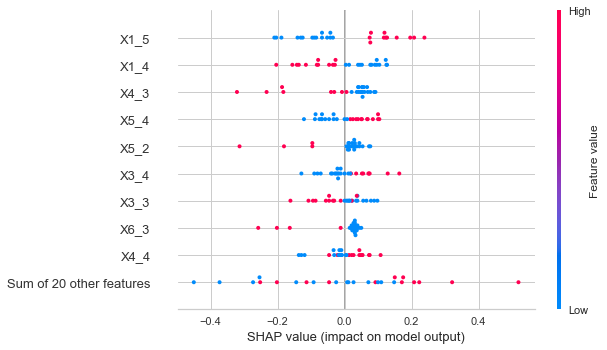

In [105]:
# Analysis using beeswarm
shap.plots.beeswarm(shap_values)

<b> While the feature importance differs between xgboost and random forest, both have the X6 variable (app makes it order easy for me) with 3 rating as the most important feature. <br>
In the case of random forest, it's by far the most important, while for xgboost it's more scattered. </br>
While using SHAP values, good scores in X1 (ordered delivered on time) explain 20% of the prediction. 

## Model evaluation

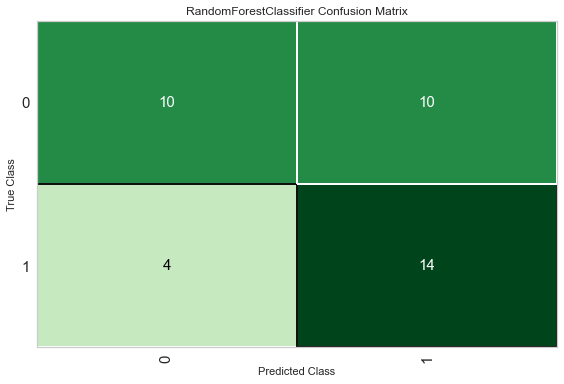

In [82]:
# Plotting confusion matrix
plot_model(rf,plot='confusion_matrix')

In [106]:
# Predict to double check on 3 main models

In [116]:
predict_model(knn)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.5263,0.5639,0.7778,0.5000,0.6087,0.0757,0.0882


,X1_1,X1_3,X1_4,X1_5,X2_1,X2_2,X2_3,X2_4,X2_5,X3_1,...,X5_3,X5_4,X5_5,X6_1,X6_3,X6_4,X6_5,Y,Label,Score
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.8
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.8
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0.6
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,1,0.6
5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,0.6
6,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0,0.6
7,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,1,0.8
8,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0.8
9,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,1,0.8


In [119]:
predict_model(xgboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.5789,0.5764,0.7778,0.5385,0.6364,0.1739,0.1910


,X1_1,X1_3,X1_4,X1_5,X2_1,X2_2,X2_3,X2_4,X2_5,X3_1,...,X5_3,X5_4,X5_5,X6_1,X6_3,X6_4,X6_5,Y,Label,Score
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.9563
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0.9862
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.9699
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0.5567
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,1,0.7099
5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,0.8500
6,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0,0.8670
7,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,1,0.9325
8,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0.7230
9,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,1,0.7835


In [128]:
predict_model(rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.6316,0.5917,0.7778,0.5833,0.6667,0.2732,0.2875


,X1_1,X1_3,X1_4,X1_5,X2_1,X2_2,X2_3,X2_4,X2_5,X3_1,...,X5_3,X5_4,X5_5,X6_1,X6_3,X6_4,X6_5,Y,Label,Score
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.8400
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0.8875
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.7850
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0.5017
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,1,0.5800
5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,0.7700
6,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0,0.8200
7,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,1,0.8900
8,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.5200
9,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,1,0.8500


### <b> Random Forest performs better on unseen data and it also has lower variance than the other two

## Conclusion and recommendation

### <b> Bottomline, a target of 73% couldn't be reached. Removing features will only decrease the score. While creating feature engineering can add more multicollinearity <b>

### My choice would be the Random Forest classifier. While KNN and XGBoost have better initial performance, they don't perform as well on unseen data and have higher variance.

### Score will increase as we have more data available or more questions added. Model selection could change by then